<a href="https://colab.research.google.com/github/jeyshalinitevosha/loanrepaymentqualityprediction/blob/main/LoanRepaymentQualityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction: Enhancing Loan Application Predictions#

In this notebook, I embark on a mission: constructing a predictive model that can discern whether a given loan application is likely to default, leveraging insights from past loan outcomes. In essence, I am tackling a binary classification task of significant importance.

##Navigating Borrower Journey: Unveiling the Process##

As I delve into this challenge, I set out to unravel the path taken by a potential borrower:

* The borrower starts by filling out a loan application.

* MoneyLion steps in to examine the application thoroughly. This involves sharing the applicant's details with experts who specialize in detecting fraud.

* If there are no clear signs of dishonest behavior, the application gets the green light.

* Once the borrower successfully deposits the loan amount, the application moves ahead and enters the funded stage.

In an ideal situation, this predictive model should come into play right after step 2 and just before step 3. Its job would be to evaluate how much risk is involved in each application. Think of it as a final safety net before giving the green light to the loan. Since step 2 already catches most of the dishonest applications, our attention can be dedicated to better understanding and managing potential risks.

#Getting Ready with Dependencies and Required Modules

In [72]:
pip install pdpbox

In [73]:
import pandas as pd
import numpy as np
from google.colab import drive
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from pdpbox import pdp

#Mounting Notebook to Drive

In [74]:
#Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Diving into Data: The Exploratory Data Analysis (EDA) Journey

Load the CSV file into a DataFrame, setting the stage for data exploration. Through EDA, we'll uncover patterns, correlations, and outliers, using visualizations to gain valuable insights.


In [75]:
#Read data into a df
loan = pd.read_csv('/content/drive/My Drive/Case Study/DS Assessment/data/loan.csv')

In [76]:
#Display the head of the df
print(loan.head())

          loanId                          anon_ssn payFrequency    apr  \
0  LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0   
3  LL-I-02272596  9be6f443bb97db7e95fa0c281d34da91            B  360.0   
4  LL-I-09542882  63b5494f60b5c19c827c7b068443752c            B  590.0   

              applicationDate  originated              originatedDate  \
0  2016-02-23T17:29:01.940000       False                         NaN   
1  2016-01-19T22:07:36.778000        True  2016-01-20T15:49:18.846000   
2  2016-08-01T13:51:14.709000       False                         NaN   
3  2015-08-06T23:58:08.880000       False                         NaN   
4  2016-06-05T22:31:34.304000       False                         NaN   

   nPaidOff  approved  isFunded             loanStatus  loanAmount  \
0       0.0     False         0  Withdrawn App

In [77]:
#Identify columns to parse as dates
date_columns = ['applicationDate', 'originatedDate']

#Read the DataFrame again, parsing specified columns as dates
loan_parsed_dates = pd.read_csv('/content/drive/My Drive/Case Study/DS Assessment/data/loan.csv', parse_dates=date_columns)

#Display the parsed DataFrame
print(loan_parsed_dates.head())

          loanId                          anon_ssn payFrequency    apr  \
0  LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0   
3  LL-I-02272596  9be6f443bb97db7e95fa0c281d34da91            B  360.0   
4  LL-I-09542882  63b5494f60b5c19c827c7b068443752c            B  590.0   

          applicationDate  originated          originatedDate  nPaidOff  \
0 2016-02-23 17:29:01.940       False                     NaT       0.0   
1 2016-01-19 22:07:36.778        True 2016-01-20 15:49:18.846       0.0   
2 2016-08-01 13:51:14.709       False                     NaT       0.0   
3 2015-08-06 23:58:08.880       False                     NaT       0.0   
4 2016-06-05 22:31:34.304       False                     NaT       0.0   

   approved  isFunded             loanStatus  loanAmount  \
0     False         0  Withdrawn Application

In [78]:
#Read data
cuv = pd.read_csv('/content/drive/My Drive/Case Study/DS Assessment/data/clarity_underwriting_variables.csv', low_memory=False)
#Display result
cuv

,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudiden

In [79]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   loanId                            577426 non-null  object 
 1   anon_ssn                          577682 non-null  object 
 2   payFrequency                      576409 non-null  object 
 3   apr                               573760 non-null  float64
 4   applicationDate                   577682 non-null  object 
 5   originated                        577682 non-null  bool   
 6   originatedDate                    46044 non-null   object 
 7   nPaidOff                          577658 non-null  float64
 8   approved                          577682 non-null  bool   
 9   isFunded                          577682 non-null  int64  
 10  loanStatus                        577291 non-null  object 
 11  loanAmount                        575432 non-null  f

In [80]:
cuv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 54 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   .underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                  49750 non-null  float64
 1   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                             49750 non-null  float64
 2   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                   49750 non-null  float64
 3   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                     49750 non-null  float64
 4   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                  49750

In [81]:
#Merge the dataframes
df = loan.merge(cuv, left_on='clarityFraudId', right_on='underwritingid', how='left')

#Filter by funded loans using boolean indexing
df = df[df['isFunded'] == 1]

#Display the filtered dataframe
print(df)

               loanId                          anon_ssn payFrequency    apr  \
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
15      LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0   
33      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
47      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0   
54      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   
...               ...                               ...          ...    ...   
577564  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8            B  565.0   
577590  LL-I-15280684  73690518af906288434b2a0cfd972fe0            M  645.0   
577617  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779            B  449.0   
577653  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c            B  625.0   
577662  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911            W  645.0   

                   applicationDate  originated     

In [82]:
#Drop columns that are of no use
df = df[['loanId',
         'anon_ssn',
         'payFrequency',
         'apr',
         'applicationDate',
         'originatedDate',
         'nPaidOff',
         'loanStatus',
         'loanAmount',
         'originallyScheduledPaymentAmount',
         'state',
         'leadType',
         'leadCost',
         'fpStatus',
         'hasCF',
         'clearfraudscore']]
df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,hasCF,clearfraudscore
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,2016-01-20T15:49:18.846000,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,1,879.0
15,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28T19:54:22.982000,2016-11-29T20:30:40.640000,2.0,New Loan,350.0,893.88,MO,organic,0,Checked,0,NaN
33,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,2017-03-01T16:15:13.016000,0.0,New Loan,400.0,1364.87,NJ,lead,40,Checked,1,658.0
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,2017-01-31T18:00:14.520000,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,1,835.0
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,2016-08-29T15:05:04.014000,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,1,624.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577564,LL-I-12367915,55392b05f72f8c3e32e5157612406ba8,B,565.0,2016-12-01T16:57:49.231000,2016-12-01T17:28:21.872000,3.0,Paid Off Loan,600.0,1670.18,CA,rc_returning,0,Checked,0,NaN
577590,LL-I-15280684,73690518af906288434b2a0cfd972fe0,M,645.0,2017-01-14T19:43:08.685000,2017-01-14T20:00:10.426000,0.0,Paid Off Loan,375.0,1042.40,AL,lead,25,Checked,1,700.0
577617,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,B,449.0,2016-06-22T01:10:50.110000,2016-06-22T21:46:54.359000,0.0,Paid Off Loan,400.0,664.12,WI,lead,40,Checked,1,806.0
577653,LL-I-14178923,d9a63e9e15b862fcaaf3653c52e1f16c,B,625.0,2016-12-30T15:49:39.785000,2016-12-30T16:00:12.500000,0.0,New Loan,600.0,1868.88,IN,lead,25,Checked,1,769.0


In [83]:
#Check the number of missing values in each column
missing_values = df.isnull().sum()

#Calculate the percentage of missing values
total_rows = df.shape[0]
missing_percentage = (missing_values / total_rows) * 100

#Create a new DataFrame to display the results
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_percentage
})

#Display the missing data summary
print(missing_data)

                                  Missing Values  Percentage Missing
loanId                                         0            0.000000
anon_ssn                                       0            0.000000
payFrequency                                   0            0.000000
apr                                            0            0.000000
applicationDate                                0            0.000000
originatedDate                                 0            0.000000
nPaidOff                                      21            0.053871
loanStatus                                     0            0.000000
loanAmount                                     0            0.000000
originallyScheduledPaymentAmount               0            0.000000
state                                          0            0.000000
leadType                                       0            0.000000
leadCost                                       0            0.000000
fpStatus                          

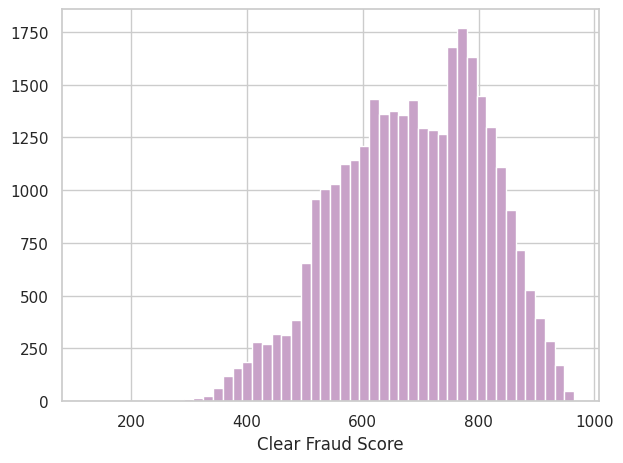

In [84]:
#Visualise clearfraudscore [histogram]
df['clearfraudscore'].plot(kind='hist', bins=50, color='#C8A2C8')
plt.xlabel('Clear Fraud Score')
plt.ylabel('')
plt.xticks
plt.yticks
plt.tight_layout()
plt.show()

The data exhibits a Gaussian (normal) distribution, with a slight negative skew indicating potential significance in utilizing the median value.

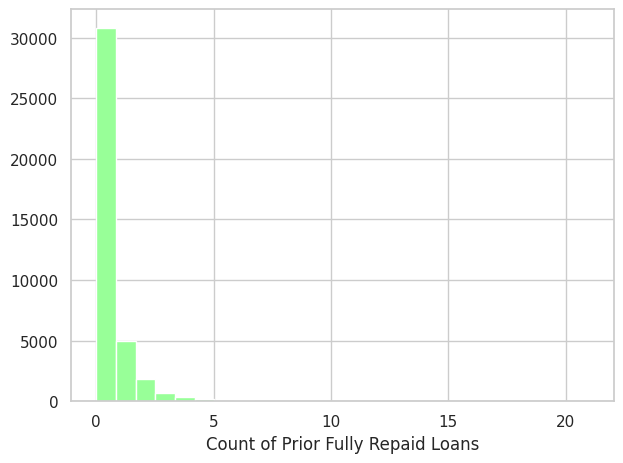

In [85]:
#Visualise nPaidOff [histogram]
df['nPaidOff'].plot(kind='hist', bins=25, color='#98FF98')
plt.xlabel('Count of Prior Fully Repaid Loans')
plt.ylabel('')
plt.xticks
plt.yticks
plt.tight_layout()
plt.show()

The data displays a strong concentration around the value 0, suggesting that the mode could be a meaningful indicator to consider.

The mode is important because it represents the value that appears most often in a dataset. When data clusters around a particular value, that becomes the mode. It helps us understand the common value in the data, aiding in making informed decisions or understanding the dataset's pattern.

In [86]:
#Handling missing values
df.loc[df['clearfraudscore'].isna(), 'clearfraudscore'] = df['clearfraudscore'].median()
df.loc[df['nPaidOff'].isna(), 'nPaidOff'] = df['nPaidOff'].mode()[0]

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38982 entries, 1 to 577662
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   loanId                            38982 non-null  object 
 1   anon_ssn                          38982 non-null  object 
 2   payFrequency                      38982 non-null  object 
 3   apr                               38982 non-null  float64
 4   applicationDate                   38982 non-null  object 
 5   originatedDate                    38982 non-null  object 
 6   nPaidOff                          38982 non-null  float64
 7   loanStatus                        38982 non-null  object 
 8   loanAmount                        38982 non-null  float64
 9   originallyScheduledPaymentAmount  38982 non-null  float64
 10  state                             38982 non-null  object 
 11  leadType                          38982 non-null  object 
 12  lea

In [88]:
#Remove unnecessary columns
df = df.drop(columns=['state', 'fpStatus'])

#Transform payFrequency using an ordinal mapping
pay_frequency_mapping = {'W': 0, 'B': 1, 'S': 2, 'M': 3, 'I': 4}
df['payFrequency'] = df['payFrequency'].map(pay_frequency_mapping)

#Perform one-hot encoding for leadType
df = pd.get_dummies(df, columns=['leadType'])

# Show the modified DataFrame
df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF,clearfraudscore,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,1,199.0,2016-01-19T22:07:36.778000,2016-01-20T15:49:18.846000,0.0,Paid Off Loan,3000.0,6395.19,0,1,879.0,0,0,0,0,0,0,0,1,0,0
15,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,1,475.0,2016-11-28T19:54:22.982000,2016-11-29T20:30:40.640000,2.0,New Loan,350.0,893.88,0,0,693.0,0,0,0,0,0,0,1,0,0,0
33,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,0,645.0,2017-03-01T15:55:41.823000,2017-03-01T16:15:13.016000,0.0,New Loan,400.0,1364.87,40,1,658.0,0,0,0,0,1,0,0,0,0,0
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,2,490.0,2017-01-31T17:48:17.381000,2017-01-31T18:00:14.520000,2.0,Paid Off Loan,1250.0,3313.78,0,1,835.0,0,0,0,0,0,0,1,0,0,0
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,1,590.0,2016-08-27T09:08:05.442000,2016-08-29T15:05:04.014000,0.0,Paid Off Loan,800.0,2432.08,10,1,624.0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577564,LL-I-12367915,55392b05f72f8c3e32e5157612406ba8,1,565.0,2016-12-01T16:57:49.231000,2016-12-01T17:28:21.872000,3.0,Paid Off Loan,600.0,1670.18,0,0,693.0,0,0,0,0,0,0,0,0,1,0
577590,LL-I-15280684,73690518af906288434b2a0cfd972fe0,3,645.0,2017-01-14T19:43:08.685000,2017-01-14T20:00:10.426000,0.0,Paid Off Loan,375.0,1042.40,25,1,700.0,0,0,0,0,1,0,0,0,0,0
577617,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,1,449.0,2016-06-22T01:10:50.110000,2016-06-22T21:46:54.359000,0.0,Paid Off Loan,400.0,664.12,40,1,806.0,0,0,0,0,1,0,0,0,0,0
577653,LL-I-14178923,d9a63e9e15b862fcaaf3653c52e1f16c,1,625.0,2016-12-30T15:49:39.785000,2016-12-30T16:00:12.500000,0.0,New Loan,600.0,1868.88,25,1,769.0,0,0,0,0,1,0,0,0,0,0



Transitioning onward, the focus shifts to establishing a target variable that indicates whether an individual loan application has entered default status or not. To achieve this, the attention turns to the loanStatus column, which furnishes a comprehensive overview of the application outcomes.

In [89]:
#Calculate the relative occurrence of distinct values in loanStatus
status_counts = df['loanStatus'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')
status_counts

Paid Off Loan                  29.31%
External Collection            29.07%
New Loan                       20.81%
Internal Collection            14.27%
Returned Item                   3.03%
Settlement Paid Off             1.82%
Settled Bankruptcy              0.83%
Pending Paid Off                0.43%
Charged Off Paid Off            0.41%
Charged Off                     0.00%
Settlement Pending Paid Off     0.00%
Name: loanStatus, dtype: object

In [90]:
#Create target variable based on loan status (0: loan default, 1: loan non-default)
def target_mapping(x):
    target_labels = {0: ['Settled Bankruptcy', 'Charged Off'],
                     1: ['Paid Off Loan', 'Settlement Paid Off']}
    for label, status_list in target_labels.items():
        if x in status_list:
            return label

#Apply target mapping to loanStatus column
df['target'] = df['loanStatus'].map(target_mapping)

#Filter out rows without target labels (indicating ongoing status)
df = df[df['target'].notna()].reset_index(drop=True)

#Display the distribution of target labels
target_distribution = df['target'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')
target_distribution

1.0    97.38%
0.0     2.62%
Name: target, dtype: object

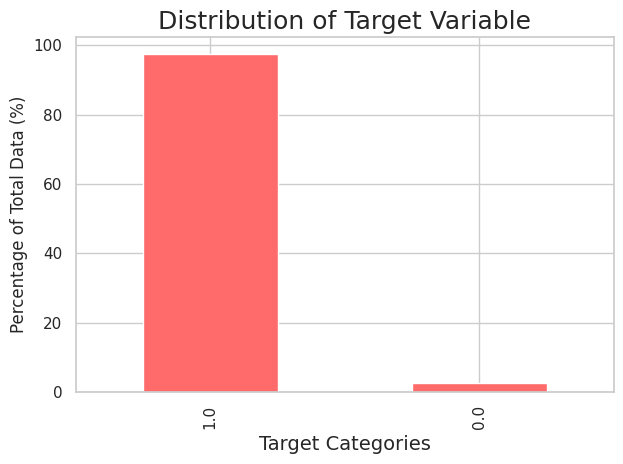

In [91]:
#Plotting the distribution of the target variable
target_distribution = df['target'].value_counts(normalize=True).apply(lambda x: round(x * 100, 2))
target_distribution.plot(kind='bar', color='#FF6B6B')

plt.title('Distribution of Target Variable', fontsize=18)
plt.xlabel('Target Categories', fontsize=14)
plt.ylabel('Percentage of Total Data (%)')
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()

As anticipated, there's a noticeable skew in favor of non-defaulted loans, creating a distinctive imbalance that demands our attention as we approach the preprocessing phase.

Intriguingly, an observation comes into focus: the time has come to part ways with the loanStatus column. It has fulfilled its role, encapsulating and presenting all essential insights within the target variable.


In [92]:
#Drop irrelevant columns
df.drop(columns=['loanStatus', 'hasCF'], inplace=True)

In [93]:
#Convert 'originatedDate' and 'applicationDate' columns to datetime format
df['originatedDate'] = pd.to_datetime(df['originatedDate'])
df['applicationDate'] = pd.to_datetime(df['applicationDate'])

#Calculate hours between applicationDate & originatedDate
df['time_to_originate'] = (df['originatedDate'] - df['applicationDate'])
print(df)

              loanId                          anon_ssn  payFrequency    apr  \
0      LL-I-06644937  464f5d9ae4fa09ece4048d949191865c             1  199.0   
1      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c             2  490.0   
2      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc             1  590.0   
3      LL-I-09279047  1d249e27292d25e4d3b4bc142a2a4aea             0  404.1   
4      LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8             0  590.0   
...              ...                               ...           ...    ...   
12456  LL-I-15390953  c81e355845a451b77c29b6515efa2578             1  645.0   
12457  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8             1  565.0   
12458  LL-I-15280684  73690518af906288434b2a0cfd972fe0             3  645.0   
12459  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779             1  449.0   
12460  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911             0  645.0   

              applicationDate          originatedDa

The code segment above converts the 'originatedDate' and 'applicationDate' columns into datetime format. It then calculates the time difference between these dates, resulting in a new 'time_to_originate' column. This column signifies the hours it takes for an application to progress from application to origination. The printed output reveals this temporal information for each entry in the dataset.

In [94]:
#Replicating the DataFrame while sorting values based on 'anon_ssn' and 'applicationDate'
sorted_df = df.sort_values(by=['anon_ssn', 'applicationDate']).copy()

#Calculating the time interval between consecutive applications
df['time_since_last'] = sorted_df.groupby('anon_ssn')['applicationDate'].diff().dt.total_seconds() / (24 * 60 * 60)

#Filling NaN values with a default value
df['time_since_last'].fillna(-1, inplace=True)
df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,clearfraudscore,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,target,time_to_originate,time_since_last
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,1,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,3000.0,6395.19,0,879.0,0,0,0,0,0,0,0,1,0,0,1.0,0 days 17:41:42.068000,-1.000000
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,2,490.0,2017-01-31 17:48:17.381,2017-01-31 18:00:14.520,2.0,1250.0,3313.78,0,835.0,0,0,0,0,0,0,1,0,0,0,1.0,0 days 00:11:57.139000,13.688801
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,1,590.0,2016-08-27 09:08:05.442,2016-08-29 15:05:04.014,0.0,800.0,2432.08,10,624.0,1,0,0,0,0,0,0,0,0,0,1.0,2 days 05:56:58.572000,-1.000000
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,0,404.1,2016-05-25 03:05:18.849,2016-05-25 15:11:36.260,3.0,300.0,422.64,0,770.0,0,0,0,0,0,0,1,0,0,0,1.0,0 days 12:06:17.411000,98.405253
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,0,590.0,2015-05-26 17:02:27.312,2015-05-26 18:45:48.024,0.0,300.0,896.87,6,693.0,1,0,0,0,0,0,0,0,0,0,1.0,0 days 01:43:20.712000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12456,LL-I-15390953,c81e355845a451b77c29b6515efa2578,1,645.0,2017-01-16 04:56:31.235,2017-01-16 05:30:10.885,0.0,1500.0,5111.56,25,925.0,0,0,0,0,1,0,0,0,0,0,1.0,0 days 00:33:39.650000,-1.000000
12457,LL-I-12367915,55392b05f72f8c3e32e5157612406ba8,1,565.0,2016-12-01 16:57:49.231,2016-12-01 17:28:21.872,3.0,600.0,1670.18,0,693.0,0,0,0,0,0,0,0,0,1,0,1.0,0 days 00:30:32.641000,-1.000000
12458,LL-I-15280684,73690518af906288434b2a0cfd972fe0,3,645.0,2017-01-14 19:43:08.685,2017-01-14 20:00:10.426,0.0,375.0,1042.40,25,700.0,0,0,0,0,1,0,0,0,0,0,1.0,0 days 00:17:01.741000,-1.000000
12459,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,1,449.0,2016-06-22 01:10:50.110,2016-06-22 21:46:54.359,0.0,400.0,664.12,40,806.0,0,0,0,0,1,0,0,0,0,0,1.0,0 days 20:36:04.249000,-1.000000


In [95]:
#Crafting a duplicate for exploratory analysis and visualization purposes
exploration_data = df.copy()

#Displaying descriptive statistics for numeric attributes
numeric_stats = exploration_data[['apr', 'nPaidOff', 'loanAmount', 'originallyScheduledPaymentAmount', 'leadCost', 'clearfraudscore', 'time_to_originate', 'time_since_last']].describe()
numeric_stats

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,clearfraudscore,time_to_originate,time_since_last
count,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461,12461.000000
mean,508.946662,0.590081,629.297007,1661.688210,12.109863,709.577482,1 days 05:44:41.316698659,26.693385
std,117.319897,1.389716,451.761168,1202.830803,24.749500,115.983220,3 days 23:51:31.857864725,72.233430
min,0.000000,0.000000,100.000000,188.410000,0.000000,177.000000,0 days 00:00:00.416000,-1.000000
25%,390.000000,0.000000,350.000000,950.230000,0.000000,655.000000,0 days 00:48:08.114000,-1.000000
50%,565.000000,0.000000,500.000000,1303.620000,3.000000,693.000000,0 days 05:12:06.010000,-1.000000
75%,590.000000,1.000000,700.000000,1943.700000,10.000000,794.000000,0 days 23:11:58.621000,-1.000000
max,705.590000,21.000000,4687.000000,12550.080000,200.000000,961.000000,245 days 08:46:52.186000,608.884541


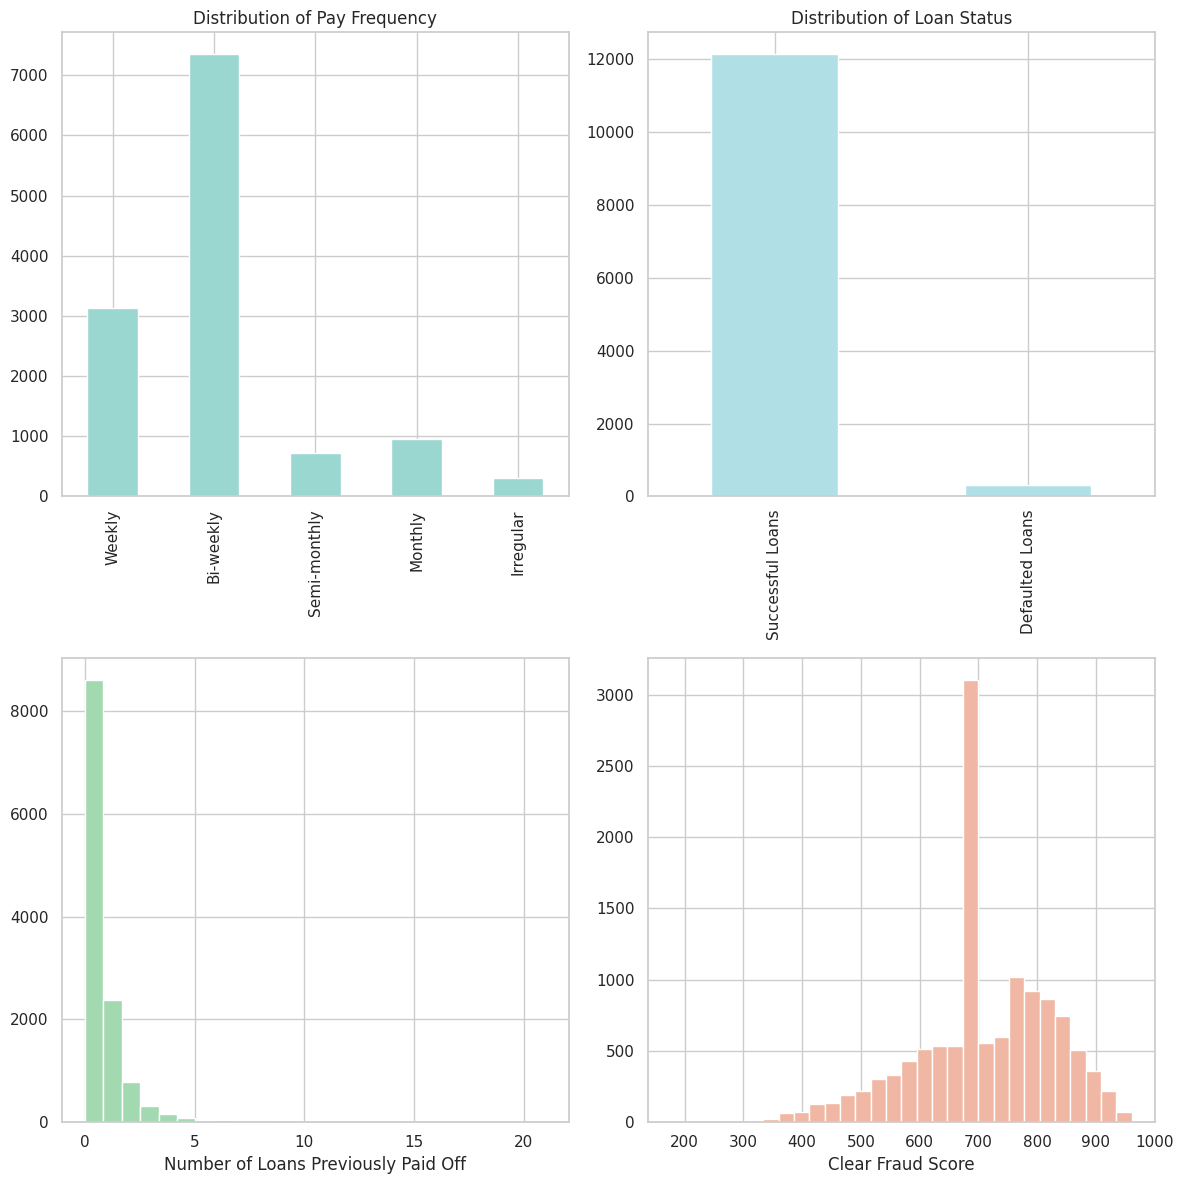

In [96]:
#Creating a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

#Plotting pay frequency distribution
exploration_data.groupby(['payFrequency']).size().plot(kind='bar', color='#9AD7D0', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Pay Frequency')
axes[0, 0].set_xlabel('')
axes[0, 0].set_xticks(range(len(['Weekly', 'Bi-weekly', 'Semi-monthly', 'Monthly', 'Irregular'])))
axes[0, 0].set_xticklabels(['Weekly', 'Bi-weekly', 'Semi-monthly', 'Monthly', 'Irregular'])

#Plotting loan status distribution
exploration_data['target'].value_counts().plot(kind='bar', color='#B0E0E6', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Loan Status')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticklabels(['Successful Loans', 'Defaulted Loans'])

#Plotting histogram for 'nPaidOff'
exploration_data['nPaidOff'].plot(kind='hist', bins=25, color='#A3D9B1', ax=axes[1, 0])
axes[1, 0].set_xlabel('Number of Loans Previously Paid Off')
axes[1, 0].set_ylabel('')

#Plotting histogram for 'clearfraudscore'
exploration_data['clearfraudscore'].plot(kind='hist', bins=30, color='#F0B7A4', ax=axes[1, 1])
axes[1, 1].set_xlabel('Clear Fraud Score')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()

The observation reveals that a significant proportion of funded loan applications adhere to either a weekly or bi-weekly repayment structure.

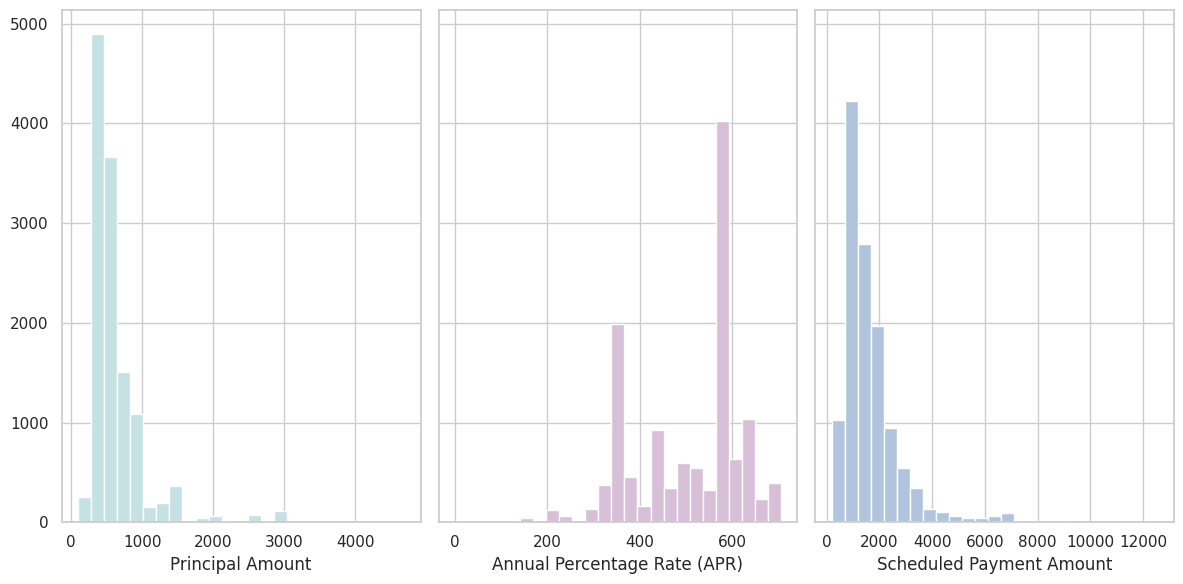

In [97]:
# Creating a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

exploration_data['loanAmount'].plot(kind='hist', bins=25, color='#C4E1E4', ax=ax[0])
exploration_data['apr'].plot(kind='hist', bins=25, color='#D8BFD8', ax=ax[1])
exploration_data['originallyScheduledPaymentAmount'].plot(kind='hist', bins=25, color='#B0C4DE', ax=ax[2])

ax[0].set_xlabel('Principal Amount')
ax[0].set_ylabel('')
ax[1].set_xlabel('Annual Percentage Rate (APR)')
ax[2].set_xlabel('Scheduled Payment Amount')

plt.tight_layout()
plt.show()


Notably, the three columns containing financial terms of the loan exhibit significant skewness. Given the undeniable relevance of these features to the current objective, a prudent approach would be to select a model resilient to skewness or normalize these data as part of the preprocessing stage.

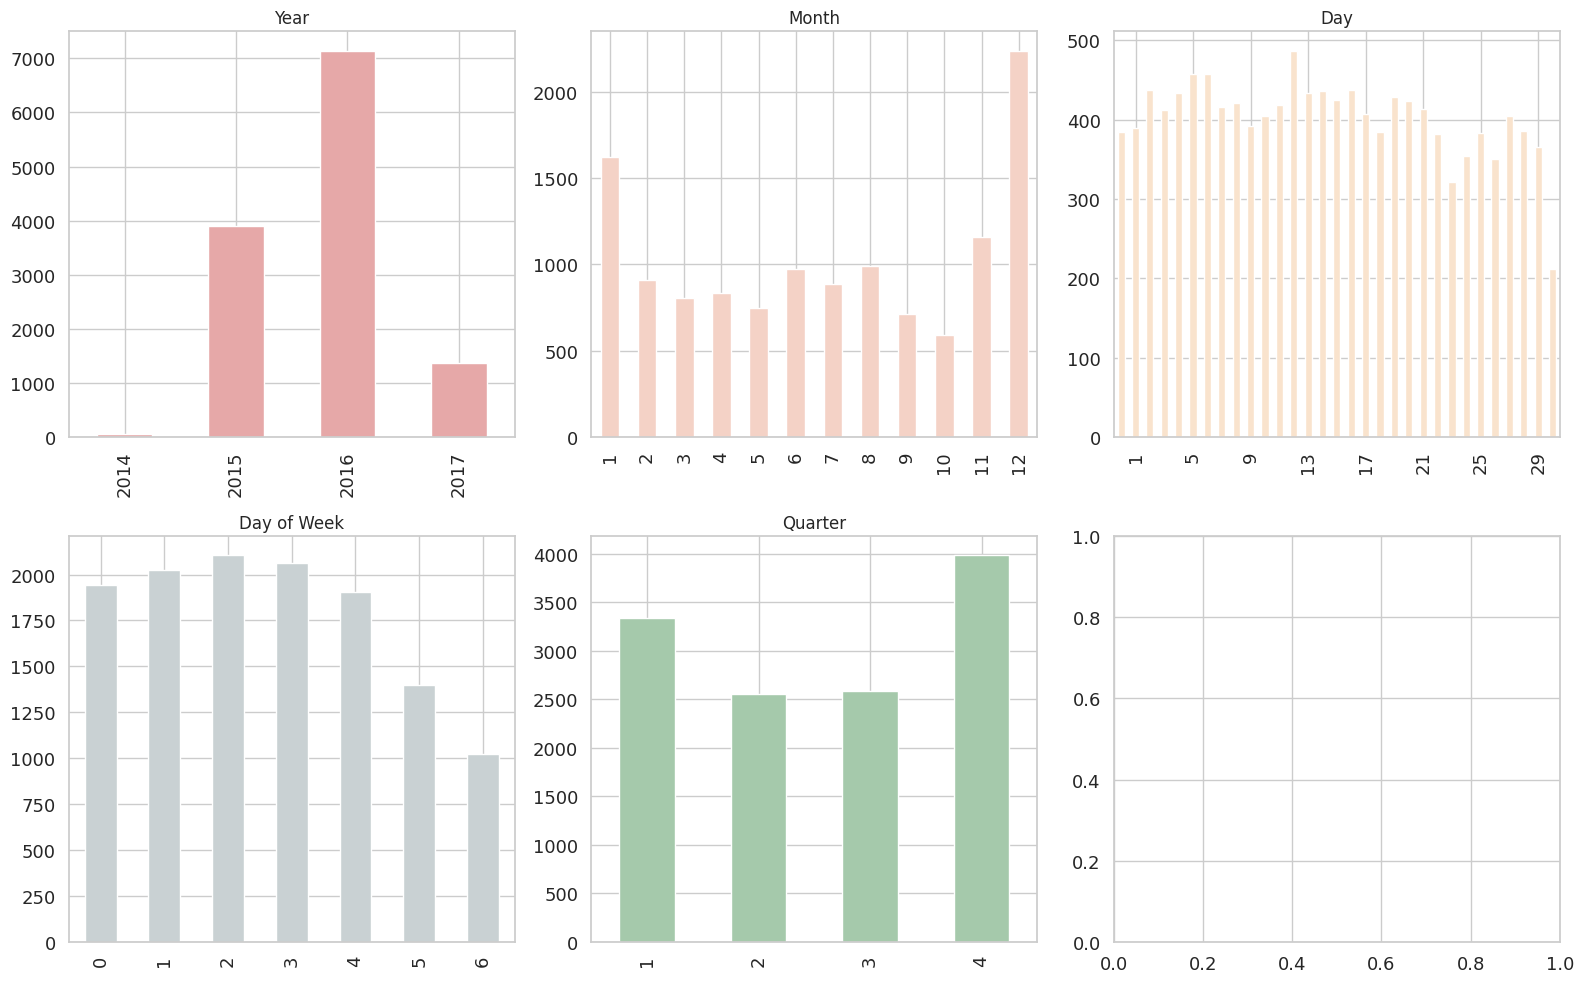

In [98]:
#Creating a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

exploration_data.groupby(exploration_data['applicationDate'].dt.year).size().plot(kind='bar', color='#E6A8A8', ax=axes[0, 0])
exploration_data.groupby(exploration_data['applicationDate'].dt.month).size().plot(kind='bar', color='#F4D2C6', ax=axes[0, 1])
exploration_data.groupby(exploration_data['applicationDate'].dt.day).size().plot(kind='bar', xticks=range(1, 31, 4), color='#F9E3CD', ax=axes[0, 2])
exploration_data.groupby(exploration_data['applicationDate'].dt.dayofweek).size().reindex([0, 1, 2, 3, 4, 5, 6]).plot(kind='bar', color='#C9D1D3', ax=axes[1, 0])
exploration_data.groupby(exploration_data['applicationDate'].dt.quarter).size().plot(kind='bar', color='#A5C9AB', ax=axes[1, 1])

axes[0, 0].set_title('Year')
axes[0, 1].set_title('Month')
axes[0, 2].set_title('Day')
axes[1, 0].set_title('Day of Week')
axes[1, 1].set_title('Quarter')

for i in range(2):
    for j in range(3):
        axes[i, j].set_xlabel('')
        axes[i, j].tick_params(axis='both', which='both', labelsize=13)

plt.tight_layout()
plt.show()

Venturing forth, the insights gleaned are as follows:

* Considering the data gaps in 2014 and 2017, an intriguing observation emerges. MoneyLion displays a notable uptick, approximately 1.75 times more loans funded in 2016 in contrast to 2015.
*A distinct concentration of loan applications surfaces around December and January, a phenomenon intertwined with the holiday season's influence. In harmony with this trend, MoneyLion allocates a substantial share of loan funding during the first and fourth quarters.
*Intriguingly, a divergence becomes evident in the realm of loan funding based on the day of application. Loans originating from weekends experience lower funding, juxtaposed against their weekday counterparts. This divergence could be attributed to the underlying observation that fewer individuals opt to submit loan applications during weekends.

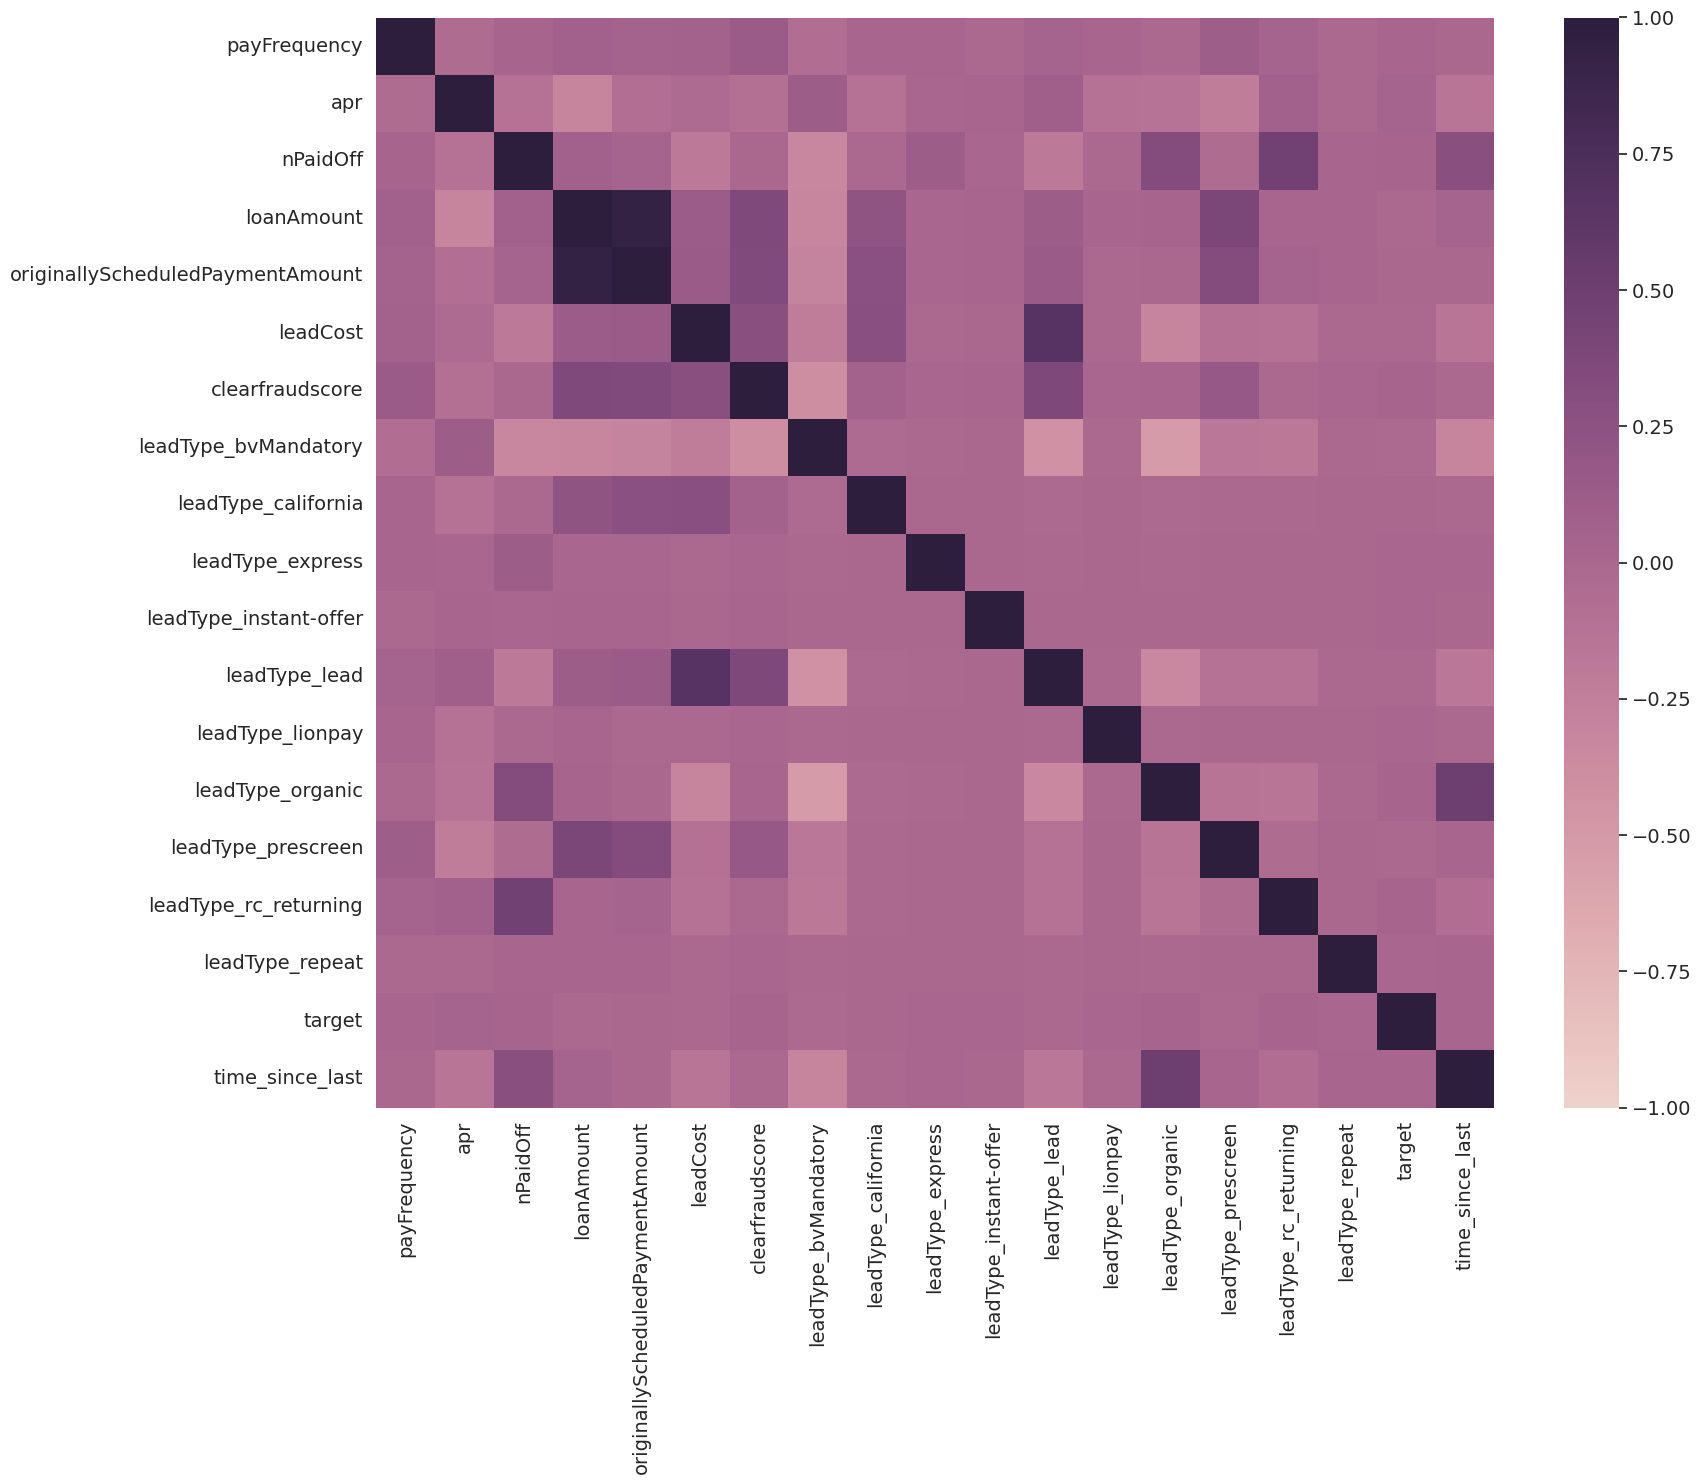

In [99]:
#Creating a correlation heatmap with cubehelix color palette
plt.figure(figsize=(18, 15))
corr_heatmap = sns.heatmap(df.corr(), vmin=-1.0, cmap=sns.cubehelix_palette(as_cmap=True), annot_kws={"fontsize": 13})

#Adjusting label font sizes
corr_heatmap.set_xticklabels(corr_heatmap.get_xticklabels(), fontsize=14)
corr_heatmap.set_yticklabels(corr_heatmap.get_yticklabels(), fontsize=14)

cbar = corr_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

#Data Preprocessing: Shaping the Path to Insight


In [100]:
#Drop irrelevant columns
df.drop(columns=['applicationDate', 'originatedDate'], inplace=True)

In [101]:
#Min-max scaling
scaler = MinMaxScaler()
df[['loanAmount', 'originallyScheduledPaymentAmount']] = scaler.fit_transform(df[['loanAmount', 'originallyScheduledPaymentAmount']])

#Z-score standardization
mean, stdev = df['clearfraudscore'].mean(), df['clearfraudscore'].std()
df['clearfraudscore'] = (df['clearfraudscore'] - mean) / stdev

In [102]:
#Initial APR: 0 -> APR after normalization: -Inf
df.iloc[[9299, 10086]]

,loanId,anon_ssn,payFrequency,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,clearfraudscore,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,target,time_to_originate,time_since_last
9299,LL-I-00526002,7996ea34884d235f656e25d9df4e8bc3,1,0.0,0.0,0.152605,0.049475,3,-0.14293,1,0,0,0,0,0,0,0,0,0,1.0,0 days 20:21:01.376000,-1.0
10086,LL-I-00260783,7edc6acb596c64104d96b3d6897d2aed,1,590.0,0.0,0.087203,0.104839,0,-0.14293,0,0,0,0,0,0,1,0,0,0,1.0,0 days 02:24:08.611000,0.0


The code snippet above selects two specific rows with indices 9299 and 10086 from the DataFrame df. These rows appear to be part of a process involving APR (Annual Percentage Rate) normalization. The comment suggests that the initial APR values are being transformed, and as a result of this transformation, the APR values for these rows are becoming negative infinity (-Inf). However, without further context or details about the specific calculations or transformations applied, the exact reason for this outcome remains unclear.

In [103]:
#Drop problematic row
df = df.drop(index=[9299, 10086]).reset_index(drop=True)

In [104]:
# Specify the normalized features
features = ['loanAmount', 'originallyScheduledPaymentAmount', 'apr', 'time_since_last', 'clearfraudscore', 'nPaidOff', 'leadCost', 'time_to_originate']
# Print descriptive statistics
df[features].describe()

,loanAmount,originallyScheduledPaymentAmount,apr,time_since_last,clearfraudscore,nPaidOff,leadCost,time_to_originate
count,12459.000000,12459.000000,12459.000000,12459.000000,12459.000000,12459.000000,12459.000000,12459
mean,0.115390,0.119188,508.981006,26.697750,0.000023,0.590176,12.111566,1 days 05:44:51.931727666
std,0.098494,0.097309,117.238421,72.238406,1.000079,1.389808,24.751115,3 days 23:51:58.297236630
min,0.000000,0.000000,29.990000,-1.000000,-4.591849,0.000000,0.000000,0 days 00:00:00.416000
25%,0.054502,0.061632,390.000000,-1.000000,-0.470564,0.000000,0.000000,0 days 00:48:07.902500
50%,0.087203,0.090215,565.000000,-1.000000,-0.142930,0.000000,3.000000,0 days 05:12:06.010000
75%,0.130804,0.141995,590.000000,-1.000000,0.727886,1.000000,10.000000,0 days 23:12:20.194500
max,1.000000,1.000000,705.590000,608.884541,2.167749,21.000000,200.000000,245 days 08:46:52.186000


In [105]:
#Separate the unique identifiers & target variable from the features
X, y = df.drop(['loanId', 'anon_ssn', 'target'], axis=1), df['target']

#Convert timedelta column to numeric representation (total seconds)
X['time_to_originate_seconds'] = X['time_to_originate'].dt.total_seconds()
X = X.drop('time_to_originate', axis=1)

#Check the class distribution before balancing
print(f'Class distribution before balancing: \n{y.value_counts(normalize=True).apply(lambda x: f"{x * 100:.2f}%")}\n')

#Balance the class distribution using oversampling
rosampler = RandomOverSampler(random_state=21)
X_resampled, y_resampled = rosampler.fit_resample(X, y)

#Check the class distribution after balancing
print(f'Class distribution after balancing: \n{y_resampled.value_counts(normalize=True).apply(lambda x: f"{x * 100:.2f}%")}\n')

Class distribution before balancing: 
1.0    97.38%
0.0     2.62%
Name: target, dtype: object

Class distribution after balancing: 
1.0    50.00%
0.0    50.00%
Name: target, dtype: object



In [106]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=11)

#From Data to Decision: Model Development

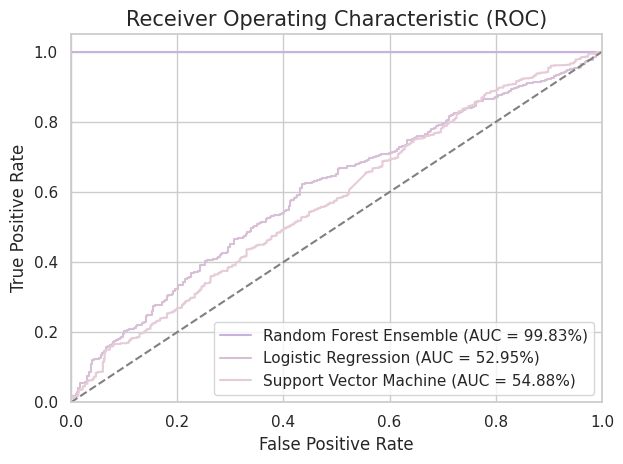

In [107]:
#Initialize classifiers
classifiers = {
    'Random Forest Ensemble': RandomForestClassifier(n_jobs=-1, random_state=11),
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=11),
    'Support Vector Machine': SVC(probability=True, random_state=11)
}

pastel_colors = ['#C9B1E0', '#D8BFD8', '#E6CCD8']

#Loop through classifiers
for i, (clf_name, classifier) in enumerate(classifiers.items()):
    #Train the classifiers on the training data
    classifier.fit(X_train, y_train)

    #Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])
    auc_score = roc_auc_score(y_test, classifier.predict(X_test)) * 100

    #Plot ROC curve with pastel color
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_score:.2f}%)', color=pastel_colors[i])

#Customize ROC graph
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Remarkably, the Random Forest Ensemble exhibits exceptional performance compared to the other three models, achieving an impressive ROC-AUC score of 99.83%!

Considering this outstanding performance, the Random Forest Ensemble becomes the chosen model for the task.

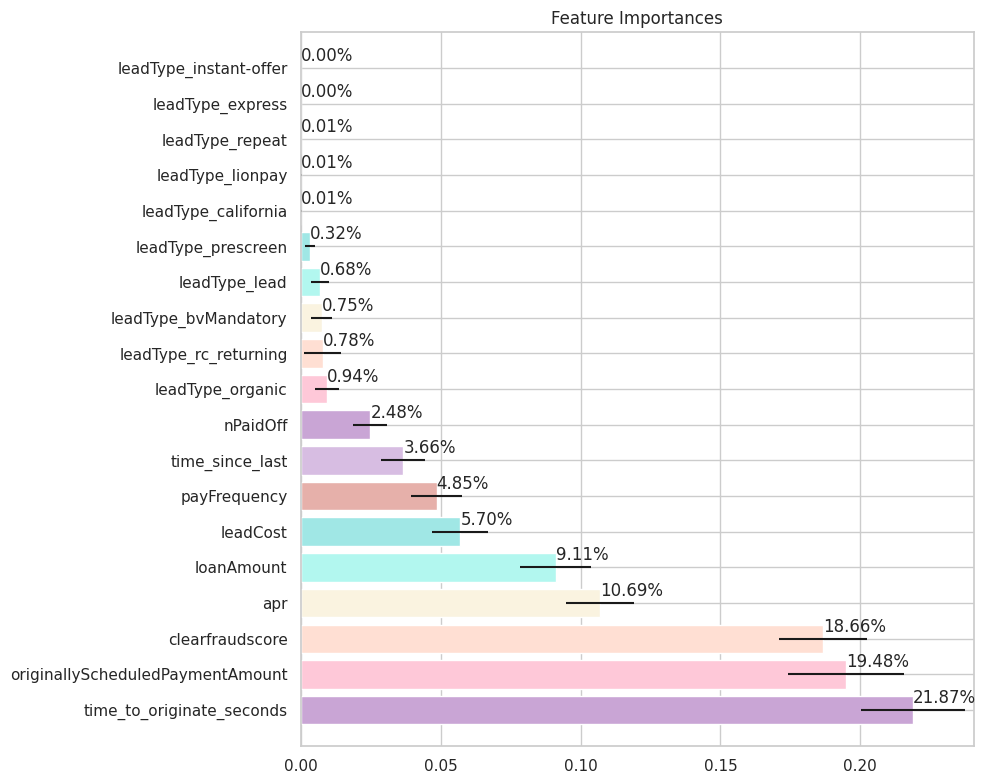

In [108]:
#Select the classifier for feature importance analysis
selected_classifier = classifiers['Random Forest Ensemble']

#Calculate and visualize feature importances
importance_scores = selected_classifier.feature_importances_
std_deviation = np.std([tree.feature_importances_ for tree in selected_classifier.estimators_], axis=0)
indices = np.argsort(importance_scores)[::-1]

pastel_colors = ['#C9A5D5', '#FEC8D8', '#FFDFD3', '#FAF3E0', '#B2F7EF', '#A0E7E5', '#E6B0AA', '#D7BDE2']

#Create a bar plot to display feature importances
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(X.shape[1]), importance_scores[indices], xerr=std_deviation[indices], align='center', color=pastel_colors)
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.xlim(0, max(importance_scores[indices]) * 1.1)
for i, score in enumerate(importance_scores[indices]):
    plt.text(score, i + 0.2, f'{score * 100:.2f}%')
plt.tight_layout()
plt.show()

Surprisingly, the diversity of lead types doesn't strongly impact our model's decisions. However, factors related to loan financials, such as loanAmount, apr, and originallyScheduledPaymentAmount, carry more weight. This aligns with our expectations.

Additionally, clearfraudscore and time_to_originate emerge as significant contributors to the model's perspective. While clearfraudscore's relevance is reasonable due to its predictive nature, the prominence of time_to_originate demands further investigation, as its significance is less apparent.

#Future Work and Conclusion

In conclusion, there are several aspects to consider for further enhancement:

Exploring the payment.csv data could offer opportunities for generating additional features related to client reliability, such as payment adherence and repayment frequency. However, caution is needed to prevent target leakages and train/test data contamination.
